In [1]:
from models.cnep import CNEP
from models.cnmp import CNMP

from data.data_generators import *
import torch


torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
batch_size = 6
n_max, m_max = 6, 6  # max number of points in context set and target set

t_steps = 100
num_demos = 24
num_classes = 1
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 6
num_val_indiv = num_val//num_classes

X: torch.Size([24, 100, 1]) Y: torch.Size([24, 100, 1]) VX: torch.Size([6, 100, 1]) VY: torch.Size([6, 100, 1])


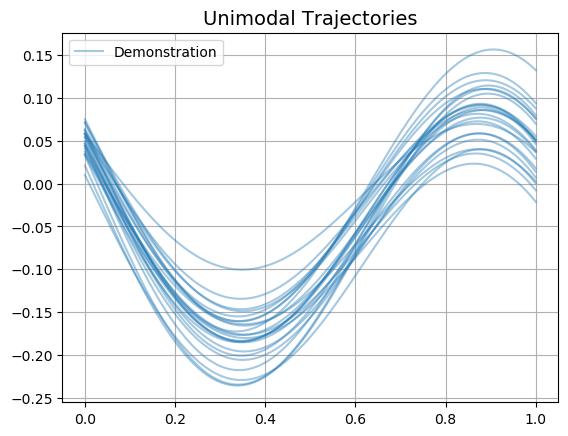

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

x = np.arange(0,1.00,0.01)
nrTraj=30
sigmaNoise=0.02

A = np.array([.2, .2, .01, -.05])
X = np.vstack((np.sin(5*x), x**2, x, np.ones((1,len(x)))))
Y = np.zeros((nrTraj, len(x)))

for traj in range(nrTraj):
    sample = -np.dot(A + sigmaNoise * np.random.randn(1,4), X)[0]
    Y[traj] = sample

x = torch.linspace(0, 1, t_steps).repeat(num_demos, 1).unsqueeze(-1)
vx = torch.linspace(0, 1, t_steps).repeat(num_val, 1).unsqueeze(-1)
all_y = torch.from_numpy(Y).float().unsqueeze(-1)
y = all_y[:num_demos]
vy = all_y[-num_val:]


for i, traj in enumerate(y):
    label = 'Demonstration' if i==0 else ''
    plt.plot(x[i], traj, color=colors[0], label=label, alpha=0.4)

plt.grid(True)
plt.legend()
plt.title(f'Unimodal Trajectories', fontsize=14)


print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)
x, y, vx, vy = x.to(device), y.to(device), vx.to(device), vy.to(device)

In [4]:
# import numpy as np
# import os

# save_path = 'data/synthetic/bimodal'

# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# try:
#     os.makedirs(f'{save_path}_0')
#     os.makedirs(f'{save_path}_1')
# except:
#     pass

# for i in range(num_demos):
#     traj = np.zeros((1, t_steps, 2))
#     traj[0, :, 0] = x[i, :, 0].cpu().numpy()
#     traj[0, :, 1] = y[i, :, 0].cpu().numpy()
        
#     np.save(f'{save_path}_{i%num_classes}/{i//num_classes}.npy', traj)

In [5]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        obs[i, :n, dx:] = traj[n_ids]
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        val_obs[i, :n, dx:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = (m_ids/t_steps).unsqueeze(1)
        val_tar_y[i] = traj[m_ids]

In [6]:
model_ = CNEP(1, 1, n_max, n_max, [128, 128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer = torch.optim.Adam(lr=1e-4, params=model_.parameters())

model0_ = CNEP(1, 1, n_max, n_max, [128, 128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer0 = torch.optim.Adam(lr=1e-4, params=model0_.parameters())
model0_.batch_entropy_coef = 0.0

model1_ = CNEP(1, 1, n_max, n_max, [128, 128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer1 = torch.optim.Adam(lr=1e-4, params=model1_.parameters())
model1_.ind_entropy_coef = 0.0

model2_ = CNEP(1, 1, n_max, n_max, [128, 128], num_decoders=1, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
optimizer2 = torch.optim.Adam(lr=1e-4, params=model2_.parameters())
model2_.batch_entropy_coef = 0.0
model2_.ind_entropy_coef = 0.0

cnmp_ = CNMP(1, 1, n_max, m_max, [128, 128], decoder_hidden_dims=[128, 128], batch_size=batch_size, device=device)
optimizer3 = torch.optim.Adam(lr=1e-4, params=cnmp_.parameters())


if torch.__version__ >= "2.0":
    model, model0, model1, model2, cnmp = torch.compile(model_), torch.compile(model0_), torch.compile(model1_), torch.compile(model2_), torch.compile(cnmp_)
else:
    model, model0, model1, model2, cnmp = model_, model0_, model1_, model2_, cnmp_

In [7]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/ablation/unimodal/orig_0_1_2_cnmp/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 3_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss, avg_loss0, avg_loss1, avg_loss2, avg_loss3 = 0, 0, 0, 0, 0

val_per_epoch = 1000
min_vl, min_vl0, min_vl1, min_vl2, min_vl3 = 1000000, 1000000, 1000000, 1000000, 1000000

mse_loss = torch.nn.MSELoss()

tl, tl0, tl1, tl2, tl3 = [], [], [], [], []
ve, ve0, ve1, ve2, ve3 = [], [], [], [], []

cnep_tl_path = f'{root_folder}cnep_training_loss.pt'
cnep_ve_path = f'{root_folder}cnep_validation_error.pt'

for epoch in range(epochs):
    epoch_loss, epoch_loss0, epoch_loss1, epoch_loss2, epoch_loss3 = 0, 0, 0, 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        prepare_masked_batch(y, traj_ids[i])

        optimizer.zero_grad()
        pred, gate = model(obs, tar_x, obs_mask)
        loss, nll = model.loss(pred, gate, tar_y, tar_mask)
        loss.backward()
        optimizer.step()


        optimizer0.zero_grad()
        pred0, gate0 = model0(obs, tar_x, obs_mask)
        loss0, nll0 = model0.loss(pred0, gate0, tar_y, tar_mask)
        loss0.backward()
        optimizer0.step()


        optimizer1.zero_grad()
        pred1, gate1 = model1(obs, tar_x, obs_mask)
        loss1, nll1 = model1.loss(pred1, gate1, tar_y, tar_mask)
        loss1.backward()
        optimizer1.step()


        optimizer2.zero_grad()
        pred2, gate2 = model2(obs, tar_x, obs_mask)
        loss2, nll2 = model2.loss(pred2, gate2, tar_y, tar_mask)
        loss2.backward()
        optimizer2.step()

        optimizer3.zero_grad()
        pred3 = cnmp(obs, tar_x, obs_mask)
        nll3 = cnmp.loss(pred3, tar_y, tar_mask)
        nll3.backward()
        optimizer3.step()

        epoch_loss += nll.item()
        epoch_loss0 += nll0.item()
        epoch_loss1 += nll1.item()
        epoch_loss2 += nll2.item()
        epoch_loss3 += nll3.item()

    epoch_loss = epoch_loss/num_demos
    epoch_loss0 = epoch_loss0/num_demos
    epoch_loss1 = epoch_loss1/num_demos
    epoch_loss2 = epoch_loss2/num_demos
    epoch_loss3 = epoch_loss3/num_demos

    tl.append(epoch_loss)
    tl0.append(epoch_loss0)
    tl1.append(epoch_loss1)
    tl2.append(epoch_loss2)
    tl3.append(epoch_loss3)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss, val_loss0, val_loss1, val_loss2, val_loss3 = 0, 0, 0, 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(vy, v_traj_ids[j])

                p, g = model.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g.squeeze(1), dim=-1)
                vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                val_loss += mse_loss(vp_means, val_tar_y).item()

                p, g = model0.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g.squeeze(1), dim=-1)
                vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                val_loss0 += mse_loss(vp_means, val_tar_y).item()

                p, g = model1.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g.squeeze(1), dim=-1)
                vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                val_loss1 += mse_loss(vp_means, val_tar_y).item()

                p, g = model2.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g.squeeze(1), dim=-1)
                vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                val_loss2 += mse_loss(vp_means, val_tar_y).item()

                p = cnmp.val(val_obs, val_tar_x, val_obs_mask)
                vp_means = p[:, :, :dy]
                val_loss3 += mse_loss(vp_means, val_tar_y).item()


            val_loss /= num_val
            val_loss0 /= num_val
            val_loss1 /= num_val
            val_loss2 /= num_val
            val_loss3 /= num_val

            ve.append(val_loss)
            ve0.append(val_loss0)
            ve1.append(val_loss1)
            ve2.append(val_loss2)
            ve3.append(val_loss3)

            if val_loss < min_vl:
                min_vl = val_loss
                print(f'New best Orig: {min_vl}')
                torch.save(model_.state_dict(), f'{root_folder}saved_models/org.pt')

            if val_loss0 < min_vl0:
                min_vl0 = val_loss0
                print(f'New best Abl 0: {min_vl0}')
                torch.save(model0_.state_dict(), f'{root_folder}saved_models/abl0.pt')

            if val_loss1 < min_vl1:
                min_vl1 = val_loss1
                print(f'New best Abl 1: {min_vl1}')
                torch.save(model1_.state_dict(), f'{root_folder}saved_models/abl1.pt')

            if val_loss2 < min_vl2:
                min_vl2 = val_loss2
                print(f'New best Abl 2: {min_vl2}')
                torch.save(model2_.state_dict(), f'{root_folder}saved_models/abl2.pt')

            if val_loss3 < min_vl3:
                min_vl3 = val_loss3
                print(f'New best Abl 3: {min_vl3}')
                torch.save(cnmp_.state_dict(), f'{root_folder}saved_models/cnmp.pt')
            
            print(f'Bests: {min_vl}, {min_vl0}, {min_vl1}, {min_vl2}, {min_vl3}')

    avg_loss += epoch_loss
    avg_loss0 += epoch_loss0
    avg_loss1 += epoch_loss1
    avg_loss2 += epoch_loss2
    avg_loss3 += epoch_loss3

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, Orig: {}, Abl0: {}, Abl1: {}, Abl2: {}, CNMP: {}".format(epoch, avg_loss/val_per_epoch, avg_loss0/val_per_epoch, avg_loss1/val_per_epoch, avg_loss2/val_per_epoch, avg_loss3/val_per_epoch))
        avg_loss, avg_loss0, avg_loss1, avg_loss2, avg_loss3 = 0, 0, 0, 0, 0

torch.save(torch.Tensor(tl), cnep_tl_path)
torch.save(torch.Tensor(ve), cnep_ve_path)
torch.save(torch.Tensor(tl0), cnep_tl_path+'_abl0')
torch.save(torch.Tensor(ve0), cnep_ve_path+'_abl0')
torch.save(torch.Tensor(tl1), cnep_tl_path+'_abl1')
torch.save(torch.Tensor(ve1), cnep_ve_path+'_abl1')
torch.save(torch.Tensor(tl2), cnep_tl_path+'_abl2')
torch.save(torch.Tensor(ve2), cnep_ve_path+'_abl2')
torch.save(torch.Tensor(tl3), cnep_tl_path+'_cnmp')
torch.save(torch.Tensor(ve3), cnep_ve_path+'_cnmp')

New best Orig: 0.001747550442814827
New best Abl 0: 0.002251704533894857
New best Abl 1: 0.004605833751459916
New best Abl 2: 0.0018302382280429204
New best Abl 3: 0.003695446066558361
Bests: 0.001747550442814827, 0.002251704533894857, 0.004605833751459916, 0.0018302382280429204, 0.003695446066558361
Epoch: 0, Orig: 0.00010006523380676906, Abl0: 0.0001009046882390976, Abl1: 9.73379835486412e-05, Abl2: 9.143155813217164e-05, CNMP: 0.0001001815249522527
New best Orig: 0.000520332483574748
New best Abl 0: 0.000605517765507102
New best Abl 1: 0.000730155191073815
New best Abl 2: 0.0006605321541428566
New best Abl 3: 0.0006831292994320393
Bests: 0.000520332483574748, 0.000605517765507102, 0.000730155191073815, 0.0006605321541428566, 0.0006831292994320393
Epoch: 1000, Orig: -0.21248596252968613, Abl0: -0.20623129831071146, Abl1: -0.19295184166112447, Abl2: -0.20808489849173945, CNMP: -0.2021670422130263
New best Orig: 0.0001884364173747599
New best Abl 0: 0.0002782710750276844
New best Abl 1

KeyboardInterrupt: 